# Analyses Machine Learning : Canaries

## Decsription des données

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Shore distance  118 non-null    int64  
 1   Depth           118 non-null    float64
 2   GM              118 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 2.9 KB
None
1    68
0    50
Name: GM, dtype: int64
                Shore distance     Depth        GM
Shore distance        1.000000  0.835184  0.461544
Depth                 0.835184  1.000000  0.560679
GM                    0.461544  0.560679  1.000000


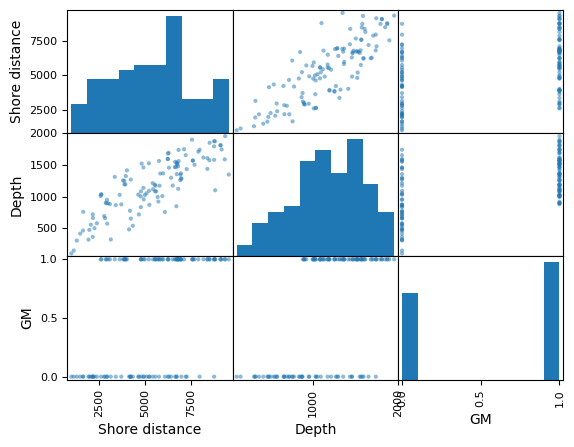

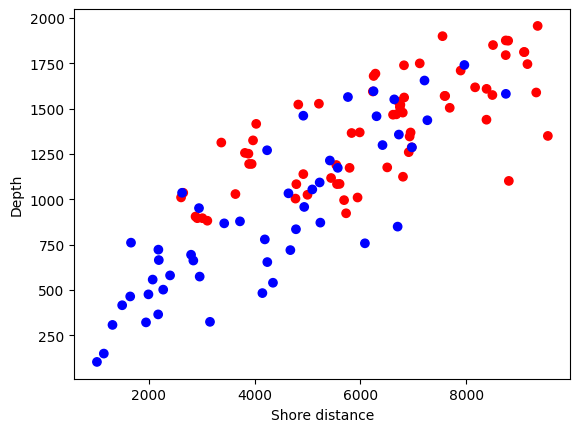


Globicephala macrorhynchus
       Shore distance        Depth    GM
count       68.000000    68.000000  68.0
mean      6268.382353  1382.889706   1.0
std       1927.263082   297.069403   0.0
min       2608.000000   882.000000   1.0
25%       4896.250000  1122.750000   1.0
50%       6562.000000  1368.750000   1.0
75%       7624.500000  1590.375000   1.0
max       9545.000000  1956.000000   1.0

Tursiops truncatus
       Shore distance        Depth    GM
count       50.000000    50.000000  50.0
mean      4213.820000   893.060000   0.0
std       2022.704793   432.496121   0.0
min       1017.000000   103.500000   0.0
25%       2302.500000   561.625000   0.0
50%       4237.000000   842.250000   0.0
75%       5716.000000  1256.375000   0.0
max       8751.000000  1740.500000   0.0

All
       Shore distance        Depth          GM
count      118.000000   118.000000  118.000000
mean      5397.805085  1175.334746    0.576271
std       2209.081757   433.547137    0.496256
min       1017.000000

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import log

variables = ['Long', 'Lat', 'Year', 'Name', 'Shore distance','Depth','Date','WKT']

df_gm = pd.read_csv('data/gm.csv', sep=';')
df_gm.columns = variables
#df_sf = pd.read_csv('data/sf.csv', sep=';')
#df_sf.columns = variables
df_tt = pd.read_csv('data/tt.csv', sep=';')

df_tt.columns = variables
df_gm['GM'] = 1
df_tt['GM'] = 0
frames = [df_gm, df_tt]

df = pd.concat(frames)
df_original = df

df = df[(df['Shore distance']>50) & (df['Shore distance']<9600) & (df['Depth']>100)]
df = df.reset_index(drop=True)

#remove outliers
for index,row in df.iterrows():
    if ((row['Shore distance']>6000 and row['Depth']<750) or (row['Long'] > -16)):
        df = df.drop(index)
        
df = df.reset_index(drop=True)
df = df.drop(['Long', 'Lat','Year','Name','Date','WKT'], axis=1)

print(df.info())
print(df['GM'].value_counts())
print(df.corr())

pd.plotting.scatter_matrix(df)
plt.show()

mask = {1: 'red', 0: 'blue'}  # Corrected the keys to integers
color = df['GM'].replace(mask)  # Corrected the method name and assigned the result back to the 'GM' column
plt.scatter(df['Shore distance'], df['Depth'], c=color)
plt.xlabel('Shore distance')
plt.ylabel('Depth')
plt.show()

print("\nGlobicephala macrorhynchus")
print(df[df['GM']==1].describe())
print("\nTursiops truncatus")
print(df[df['GM']==0].describe())
print("\nAll")
print(df.describe())

## Régression logistique

0.7659574468085106
Accuracy score:  0.75


,coef
constante,-3.761544
Shore distance,-0.000036
Depth,0.003728


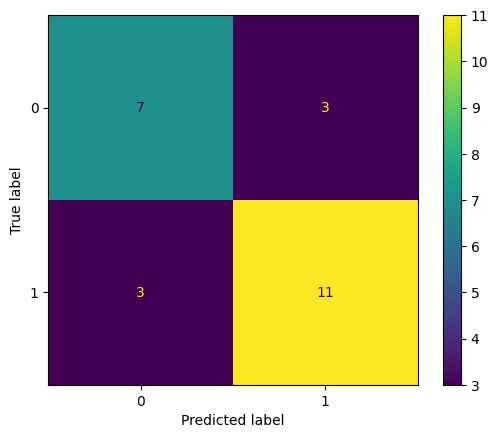

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# on définit X et y

X = df.drop(['GM'],axis=1)
y = df['GM']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

modele_logit = LogisticRegression(penalty='none') #,solver='liblinear')
modele_logit.fit(X_train,y_train)

score = modele_logit.score(X_train,y_train)
print(score)

predict = modele_logit.predict(X_test)

cm = confusion_matrix(y_test,predict)
acs = accuracy_score(y_test,predict)
print('Accuracy score: ', acs)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

pd.DataFrame(np.concatenate([modele_logit.intercept_.reshape(-1,1),
                             modele_logit.coef_],axis=1),
             index = ["coef"],
             columns = ["constante"]+list(X.columns)).T



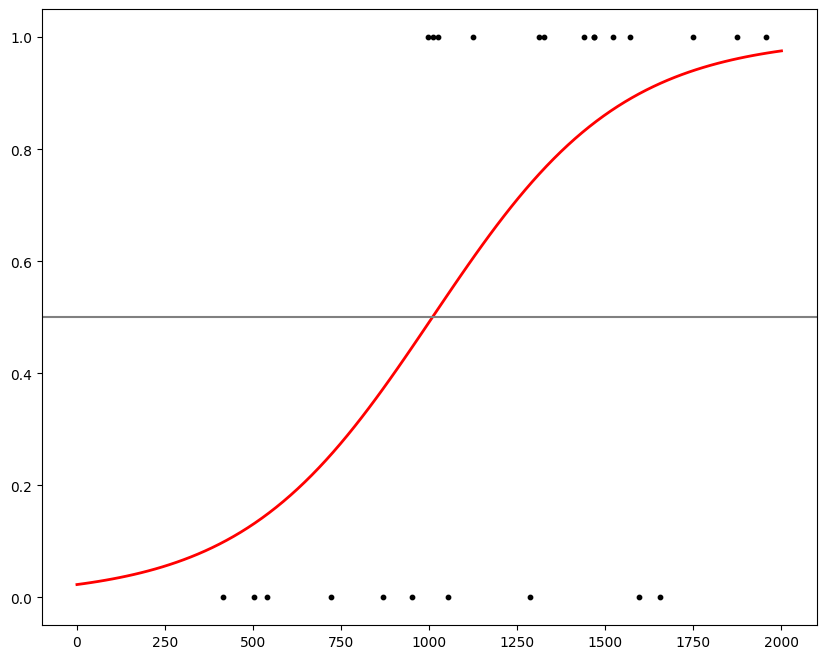

X values when Y=0.5: [1009.03914248]


In [23]:
#https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html#sphx-glr-auto-examples-linear-model-plot-logistic-py

from scipy.special import expit, logit
# and plot the result
plt.figure(1, figsize=(10, 8))

X_test_2 = X_test.iloc[:,-1] #keep Depth columns
plt.scatter(X_test_2, y_test, label="example data", color="black", zorder=20,s=10)
#plt.scatter(X.iloc[:,-1], y, label="example data", color="black", zorder=20)

X_test_ = np.linspace(0, 2000, 100) #get points to draw log
loss = expit(X_test_ * modele_logit.coef_[:,1] + modele_logit.intercept_).ravel()
plt.plot(X_test_, loss, label="Logistic Regression Model", color="red", linewidth=2)

plt.axhline(0.5, color=".5")

plt.show()

#calcul de la profondeur quand P=0.5
# Calculate logit(0.5) 
logit_05 = logit(0.5)
# Solve for X
X_05 = (logit_05 - modele_logit.intercept_) / modele_logit.coef_[:, 1]

print("X values when Y=0.5:", X_05)

## Régression logistique stats

In [15]:
import statsmodels.api as sm

# on ajoute une colonne pour la constante
x_stat = sm.add_constant(X)
# on ajuste le modèle
model = sm.Logit(y, x_stat)
result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.502485
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     GM   No. Observations:                  118
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                            2
Date:                Wed, 17 Apr 2024   Pseudo R-squ.:                  0.2626
Time:                        12:58:40   Log-Likelihood:                -59.293
converged:                       True   LL-Null:                       -80.413
Covariance Type:            nonrobust   LLR p-value:                 6.726e-10
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.7356      0.808     -4.625      0.000      -5.319      -2.153
Shore distance -2.067e-05      0.000     -0.118      0.906      -0.000       0.000
Depth              0.0036      0.001      3.573      0.000       0.002       0.006
==================================================================================
"""

## SVM

confusion matrix = 
 [[ 8  2]
 [ 2 12]]
accuracy score =  0.8333333333333334


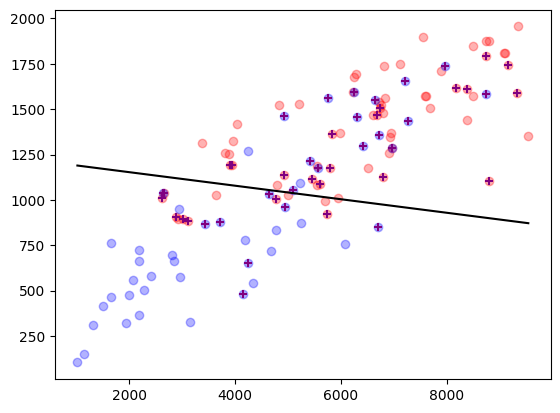

In [16]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.model_selection import train_test_split,cross_val_score

# on définit X et y
X = df.drop(['GM'],axis=1)
y = df['GM']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

classifier = svm.SVC(kernel="linear")

model = classifier.fit(X_train,y_train)
y_predict = model.predict(X_test)

print ( "confusion matrix = \n" , confusion_matrix(y_test, y_predict) )
print ( "accuracy score = ",accuracy_score(y_test,y_predict) )
classifier.support_vectors_[0:5,:]

mask_gm = df[df["GM"] == 1]
mask_tt = df[df["GM"] == 0]

plt.scatter(mask_gm['Shore distance'],mask_gm['Depth'], color="red",label="GM",alpha=0.3)
plt.scatter(mask_tt['Shore distance'],mask_tt['Depth'], color="blue",label="TT",alpha=0.3)


plt.scatter(classifier.support_vectors_[:,0],classifier.support_vectors_[:,1],marker="+",color="purple",label="support vectors")

# Get the weight (coef_) and intercept from the trained SVM model
w = classifier.coef_[0]
b = classifier.intercept_[0]

# Plot the decision boundary
xx = np.linspace(X['Shore distance'].min(), X['Shore distance'].max(), 100)
yy = (-w[0] / w[1]) * xx - b / w[1]

plt.plot(xx, yy, 'k-')
plt.show()

## Decision Tree

confusion matrix = 
 [[ 8  2]
 [ 0 14]]
accuracy score =  0.9166666666666666


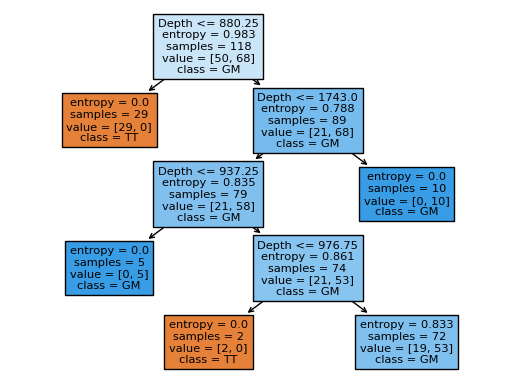

In [17]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

classifier = DecisionTreeClassifier(max_depth=4, criterion='entropy')

model = classifier.fit(X_train,y_train)
y_predict = model.predict(X_test)

model = classifier.fit(X,y)

#print(df)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print ( "confusion matrix = \n" , confusion_matrix(y_test, y_predict) )
print ( "accuracy score = ",accuracy_score(y_test,y_predict) )
#tree.plot_tree?

tree.plot_tree(model,max_depth=4, feature_names=X_train.columns, class_names=['TT','GM'],filled=True)
plt.show()

## K-Means Clustering

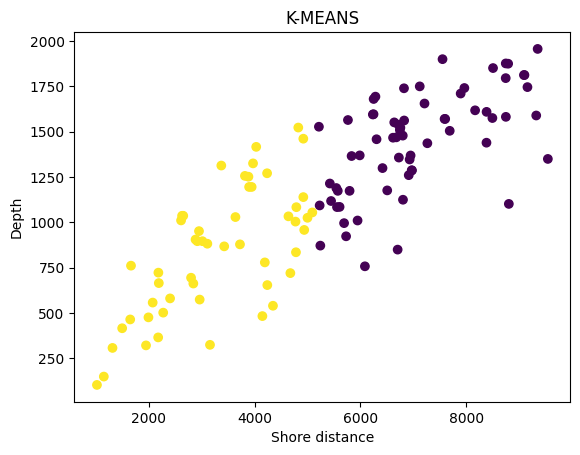

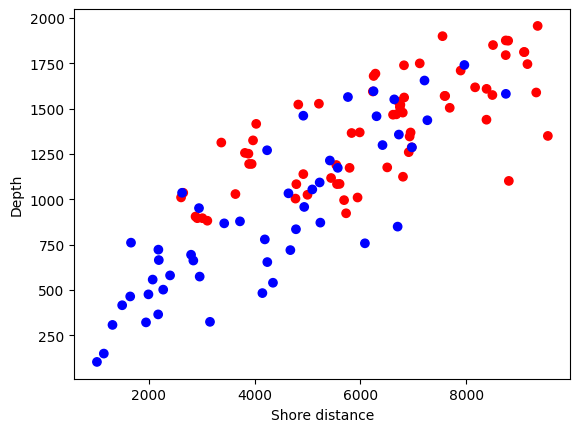

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#nb_features = 2 par défaut
#plt.scatter(X['Shore distance'], X['Depth'])
#plt.show()

# Entrainer le modele de K-mean Clustering
model = KMeans(n_clusters=2)
model.fit(X)

#Visualiser les Clusters
predictions = model.predict(X)
plt.title("K-MEANS")
plt.scatter(X['Shore distance'], X['Depth'], c=predictions)
plt.xlabel('Shore distance')
plt.ylabel('Depth')
plt.show()

mask = {1: 'red', 0: 'blue'} 
color = df['GM'].replace(mask)
plt.scatter(df['Shore distance'], df['Depth'], c=color)
plt.xlabel('Shore distance')
plt.ylabel('Depth')
plt.show()